In [3]:
from pathlib import Path
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm

In [4]:
# random_seed = 0
# np.random.seed(random_seed)
# torch.manual_seed(random_seed)
# random.seed(random_seed)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
image_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from numpy.random import RandomState
from torch.utils.data import Subset

from easyfsl.samplers import TaskSampler


batch_size = 128
n_workers = 1

cifar_data = CIFAR10(root="data", train=True, download=True,  transform= transforms.Compose([
            # transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            # transforms.GaussianBlur(3),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]))

cifar_data_val = CIFAR10(root='.',train=True, transform= transforms.Compose([
            # transforms.RandomResizedCrop(image_size),
            # transforms.RandomHorizontalFlip(),
            
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]), download=True)

n_way = 2
n_shot = 20
n_query = 5
n_tasks_per_epoch = 10
n_validation_tasks = 200

def get_dataloader(dataset,dataset_val, n_workers, seed):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 500))
    classes =  prng.permutation(np.arange(0,10))
    indx_train = np.concatenate([np.where(np.array(dataset.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(dataset_val.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])
    train_targets = np.array(dataset.targets)[indx_train]
    val_targets = np.array(dataset.targets)[indx_val]
    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data_val, indx_val)
    
    # print images from train
    
    
    
    train_data.get_labels = lambda: [
        t for t in train_targets
    ] 
    val_data.get_labels = lambda: [
        t for t in val_targets
    ] 
    train_sampler = TaskSampler(
        train_data, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_tasks_per_epoch
    )
    val_sampler = TaskSampler(
        val_data, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
    )

    train_loader = DataLoader(
        train_data,
        batch_sampler=train_sampler,
        num_workers=n_workers,
        pin_memory=True,
        collate_fn=train_sampler.episodic_collate_fn,
    )
    
    val_loader = DataLoader(
        val_data,
        batch_sampler=val_sampler,
        num_workers=n_workers,
        pin_memory=True,
        collate_fn=val_sampler.episodic_collate_fn,
    )
    
    return train_loader, val_loader
    
random_seed = 0


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


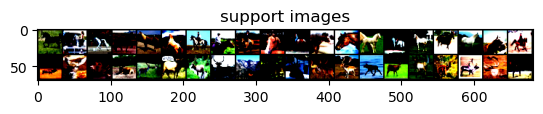

In [24]:
from easyfsl.utils import plot_images
train_loader, val_loader = get_dataloader(cifar_data,cifar_data_val, n_workers, 0)

(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=n_shot)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


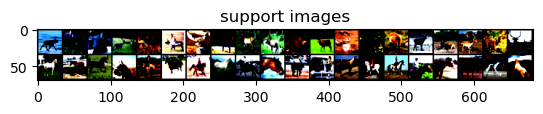

In [25]:
train_loader, val_loader = get_dataloader(cifar_data,cifar_data_val, n_workers, 0)

(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=n_shot)

In [6]:
from easyfsl.modules import resnet12, resnet50, resnet34
from torchvision.models import resnet18

DEVICE = "cuda"

# model = resnet18(
#     pretrained=True, 
# )

# model.fc = nn.Sequential(
#     nn.Linear(512, 256), 
#     nn.ReLU(),
#     nn.Linear(256, 256),
#     nn.Linear(256, 10)
# )


backbone = resnet12()


In [28]:
from easyfsl.methods import PrototypicalNetworks, LaplacianShot, MatchingNetworks, SimpleShot, TransductiveFinetuning, PTMAP, BDCSPN

from torch.optim import SGD, Optimizer, Adam
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, ReduceLROnPlateau
from timm.optim import RAdam, Lion
from timm.loss import LabelSmoothingCrossEntropy,BinaryCrossEntropy
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.scheduler.poly_lr import PolyLRScheduler
from timm.scheduler.tanh_lr import TanhLRScheduler

LOSS_FUNCTION = LabelSmoothingCrossEntropy()

n_epochs = 50
scheduler_milestones = [120, 180]
scheduler_gamma = 0.1
learning_rate = 0.1




def get_optimizer(model, name, learning_rate=0.1):
    if name == 'sgd':
        return SGD(
            model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    elif name == 'radam':
        return RAdam(
            model.parameters(), lr=learning_rate, weight_decay=5e-4
        )
    elif name == 'adam':
        return Adam(
            model.parameters(), lr=learning_rate, 
        )
    elif name == 'lion':
        return Lion(
            model.parameters(), lr=learning_rate, weight_decay=5e-4
        )
    else:
        raise ValueError(f'Optimizer {name} not found')

def get_scheduler(optimizer, name):
    if name == 'lronplateau':
        return ReduceLROnPlateau(
            optimizer, mode='min', factor=0.05, patience=15
        )
    elif name == 'cosine':
        return CosineLRScheduler(
            optimizer, t_initial=10
        )
    elif name == 'tanh':
        return TanhLRScheduler(
            optimizer, t_initial=10
        )
    elif name == 'poly':
        return PolyLRScheduler(
            optimizer, t_initial=10
        )
    else:
        raise ValueError(f'Scheduler {name} not found')
    
def get_model(name, backbone):
    if name == 'protonets':
        return PrototypicalNetworks(backbone)
    elif name == 'laplacianshot':
        return LaplacianShot(backbone)
    elif name == 'bdcspn':
        return BDCSPN(backbone)
    else:
        raise ValueError(f'Model {name} not found')
    
models = ['protonets','laplacianshot','bdcspn']
optimizers = ['sgd','radam',  'adam','lion']
schedulers = ['lronplateau', 'cosine','tanh', 'poly']



In [27]:
def training_epoch(
    model, data_loader: DataLoader, optimizer: Optimizer
):

    all_loss = []
    accuracies = []
    model.train()
    
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in enumerate(data_loader):
        optimizer.zero_grad()
        model.process_support_set(
            support_images.to(DEVICE), support_labels.to(DEVICE)
        )
        classification_scores = model(query_images.to(DEVICE))
        # print(classification_scores.shape, query_labels.shape)
        loss = LOSS_FUNCTION(classification_scores, query_labels.to(DEVICE))
        loss.backward()
        optimizer.step()
        accuracy = (classification_scores.argmax(dim=1) == query_labels.to(DEVICE)).float().mean()
        accuracies.append(accuracy.item())
        all_loss.append(loss.item())

        # tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss), all_loss, accuracies

In [30]:
from easyfsl.utils import evaluate
import json

# best_state = model.state_dict()
best_validation_accuracy = 0.0
validation_frequency = 10

backbone = resnet12()

metrics_map = {}
n_epochs = 10
for model_name in models:
    for optimizer_name in optimizers:
        for scheduler_name in schedulers:
            lr = 0.1
            model = get_model(model_name, backbone)
            model = model.to(DEVICE)
            train_optimizer = get_optimizer(model, optimizer_name, lr)
            train_scheduler = get_scheduler(train_optimizer, scheduler_name)
            

            model_info = {'model': model_name, 'optimizer': optimizer_name, 'scheduler': scheduler_name}
            
            print(f"\n\n\nModel: {model_name}, Optimizer: {optimizer_name}, Scheduler: {scheduler_name}\n")
            model_json = json.dumps(model_info)
            
            #metrics
            losses = []
            accuracies = []
            validation_accuracies = []
            times = []
            
            for seed in range(5):
                start = torch.cuda.Event(enable_timing=True)
                start.record()

                train_loader, val_loader = get_dataloader(cifar_data,cifar_data_val, n_workers, seed)
                
                for epoch in range(n_epochs):
                    # print(f"Epoch {epoch}")
                    average_loss, loss, accuracy = training_epoch(model, train_loader, train_optimizer)

                    train_scheduler.step(average_loss)
                    if epoch % 10 == 0:
                        print(f"Epoch {epoch} - Loss: {average_loss}, lr: {train_optimizer.param_groups[0]['lr']}")
                    
                    losses = np.append(losses,loss)
                    accuracies = np.append(accuracies, accuracy)
                end = torch.cuda.Event(enable_timing=True)
                end.record()
                #wait for everything to finish running
                torch.cuda.synchronize()
                print(f'Time: {start.elapsed_time(end)/1000:.3f}s')
                times = np.append(times,start.elapsed_time(end))
                
                validation_accuracy = evaluate(
                    model, val_loader, device=DEVICE, tqdm_prefix="Validation"
                )
                validation_accuracies = np.append(validation_accuracies, validation_accuracy)
                validation_accuracies= np.array(validation_accuracies)
                losses = np.array(losses)
                accuracies = np.array(accuracies)
                times = np.array(times)
                
            print(
                f"Accuracy: {100* np.array(validation_accuracies).mean():.3f}% \u00B1 {100*np.array(validation_accuracies).std():.3f}% time: {times.mean()/1000}s +- {times.std()/1000}s"
            )
            metrics_map[model_json]= {'losses': losses, 'accuracies': accuracies, 'validation_accuracies': validation_accuracies, 'times': times}
            
        
times = np.array(times)
print(
        f"Accuracy: {100* np.array(validation_accuracies).mean():.3f}% \u00B1 {100*np.array(validation_accuracies).std():.3f}% time: {times.mean()/1000}s +- {times.std()/1000}s"
    )




Model: protonets, Optimizer: sgd, Scheduler: lronplateau

Epoch 0 - Loss: 0.6383400738239289, lr: 0.1
Time: 3.990s


Validation: 100%|██████████| 200/200 [00:02<00:00, 89.79it/s, accuracy=0.641]


Epoch 0 - Loss: 0.6768024057149887, lr: 0.1
Time: 3.644s


Validation: 100%|██████████| 200/200 [00:02<00:00, 87.86it/s, accuracy=0.624]


Epoch 0 - Loss: 0.5545568138360977, lr: 0.1
Time: 3.589s


Validation: 100%|██████████| 200/200 [00:02<00:00, 90.59it/s, accuracy=0.793]


Epoch 0 - Loss: 0.4548268854618073, lr: 0.1
Time: 3.586s


Validation: 100%|██████████| 200/200 [00:02<00:00, 91.53it/s, accuracy=0.749]


Epoch 0 - Loss: 0.4309162974357605, lr: 0.1
Time: 3.589s


Validation: 100%|██████████| 200/200 [00:02<00:00, 91.16it/s, accuracy=0.866]


Accuracy: 73.450% ± 9.164% time: 3.679626611328125s +- 0.1567589565960721s



Model: protonets, Optimizer: sgd, Scheduler: cosine

Epoch 0 - Loss: 0.6342871308326721, lr: 0.09901059518576283
Time: 3.590s


Validation: 100%|██████████| 200/200 [00:02<00:00, 86.54it/s, accuracy=0.698]


Epoch 0 - Loss: 0.5004079848527908, lr: 0.09938341409646692
Time: 3.682s


Validation: 100%|██████████| 200/200 [00:02<00:00, 90.29it/s, accuracy=0.649]


Epoch 0 - Loss: 0.34898891150951383, lr: 0.09969978808132568
Time: 3.659s


Validation: 100%|██████████| 200/200 [00:02<00:00, 88.99it/s, accuracy=0.812]


Epoch 0 - Loss: 0.4731336921453476, lr: 0.09944867490376581
Time: 3.726s


Validation: 100%|██████████| 200/200 [00:02<00:00, 84.27it/s, accuracy=0.759]


Epoch 0 - Loss: 0.3876222908496857, lr: 0.09962972832603506
Time: 3.732s


Validation: 100%|██████████| 200/200 [00:02<00:00, 85.99it/s, accuracy=0.881]


Accuracy: 76.000% ± 8.193% time: 3.6778256347656253s +- 0.051911130460607795s



Model: protonets, Optimizer: sgd, Scheduler: tanh

Epoch 0 - Loss: 0.5053171396255494, lr: 0.09999977155105756
Time: 3.789s


Validation: 100%|██████████| 200/200 [00:02<00:00, 85.27it/s, accuracy=0.681]


Epoch 0 - Loss: 0.4565774857997894, lr: 0.09999979276909737
Time: 3.833s


Validation: 100%|██████████| 200/200 [00:02<00:00, 83.36it/s, accuracy=0.607]


Epoch 0 - Loss: 0.35622739791870117, lr: 0.0999998304523778
Time: 3.815s


Validation: 100%|██████████| 200/200 [00:02<00:00, 84.58it/s, accuracy=0.82] 


Epoch 0 - Loss: 0.372834300994873, lr: 0.09999982472650314
Time: 3.889s


Validation: 100%|██████████| 200/200 [00:02<00:00, 84.36it/s, accuracy=0.746]


Epoch 0 - Loss: 0.31561705470085144, lr: 0.09999984367873352
Time: 3.878s


Validation: 100%|██████████| 200/200 [00:02<00:00, 83.25it/s, accuracy=0.875]


Accuracy: 74.580% ± 9.536% time: 3.8407086914062503s +- 0.03778000036856559s



Model: protonets, Optimizer: sgd, Scheduler: poly

Epoch 0 - Loss: 0.40625781416893003, lr: 0.09794765023128973
Time: 3.884s


Validation: 100%|██████████| 200/200 [00:02<00:00, 82.29it/s, accuracy=0.679]


Epoch 0 - Loss: 0.34133470952510836, lr: 0.09827850879248673
Time: 3.940s


Validation: 100%|██████████| 200/200 [00:02<00:00, 82.92it/s, accuracy=0.659]


Epoch 0 - Loss: 0.28416263610124587, lr: 0.09856894725976713
Time: 3.955s


Validation: 100%|██████████| 200/200 [00:02<00:00, 83.59it/s, accuracy=0.816]


Epoch 0 - Loss: 0.3350922763347626, lr: 0.09831026255516379
Time: 3.962s


Validation: 100%|██████████| 200/200 [00:02<00:00, 82.79it/s, accuracy=0.75] 


Epoch 0 - Loss: 0.27846270352602004, lr: 0.09859785644969155
Time: 4.011s


Validation: 100%|██████████| 200/200 [00:02<00:00, 83.18it/s, accuracy=0.873]


Accuracy: 75.530% ± 8.048% time: 3.95015263671875s +- 0.040733783224626494s



Model: protonets, Optimizer: radam, Scheduler: lronplateau

Epoch 0 - Loss: 0.5329983353614807, lr: 0.1
Time: 4.114s


Validation: 100%|██████████| 200/200 [00:02<00:00, 81.81it/s, accuracy=0.631]


Epoch 0 - Loss: 0.727935391664505, lr: 0.1
Time: 4.202s


Validation: 100%|██████████| 200/200 [00:02<00:00, 83.51it/s, accuracy=0.584]


Epoch 0 - Loss: 0.5632230281829834, lr: 0.1
Time: 4.211s


Validation: 100%|██████████| 200/200 [00:02<00:00, 83.68it/s, accuracy=0.765]


Epoch 0 - Loss: 0.5472446024417877, lr: 0.1
Time: 4.151s


Validation: 100%|██████████| 200/200 [00:02<00:00, 83.18it/s, accuracy=0.657]


Epoch 0 - Loss: 0.3929552510380745, lr: 0.1
Time: 4.158s


Validation: 100%|██████████| 200/200 [00:02<00:00, 82.03it/s, accuracy=0.816]


Accuracy: 69.060% ± 8.646% time: 4.1671368164062494s +- 0.035530152294209395s



Model: protonets, Optimizer: radam, Scheduler: cosine

Epoch 0 - Loss: 0.6907862901687623, lr: 0.09882720520316353
Time: 4.237s


Validation: 100%|██████████| 200/200 [00:02<00:00, 81.59it/s, accuracy=0.542]


Epoch 0 - Loss: 0.7013272762298584, lr: 0.09879128582884737
Time: 4.254s


Validation: 100%|██████████| 200/200 [00:02<00:00, 82.12it/s, accuracy=0.591]


Epoch 0 - Loss: 0.6308605760335922, lr: 0.09902122134359546
Time: 4.240s


Validation: 100%|██████████| 200/200 [00:02<00:00, 80.76it/s, accuracy=0.812]


Epoch 0 - Loss: 0.6732820510864258, lr: 0.09888566945005928
Time: 4.229s


Validation: 100%|██████████| 200/200 [00:02<00:00, 80.41it/s, accuracy=0.648]


Epoch 0 - Loss: 0.5576195746660233, lr: 0.09923474735843124
Time: 4.223s


Validation: 100%|██████████| 200/200 [00:02<00:00, 80.08it/s, accuracy=0.775]


Accuracy: 67.360% ± 10.415% time: 4.236600390625s +- 0.010467183851009951s



Model: protonets, Optimizer: radam, Scheduler: tanh

Epoch 0 - Loss: 0.7085406661033631, lr: 0.09999965699032765
Time: 4.205s


Validation: 100%|██████████| 200/200 [00:02<00:00, 74.66it/s, accuracy=0.637]


Epoch 0 - Loss: 0.5564658433198929, lr: 0.0999997469442298
Time: 4.210s


Validation: 100%|██████████| 200/200 [00:02<00:00, 81.12it/s, accuracy=0.64] 


Epoch 0 - Loss: 0.4727115973830223, lr: 0.09999978597308067
Time: 4.207s


Validation: 100%|██████████| 200/200 [00:02<00:00, 79.08it/s, accuracy=0.752]


Epoch 0 - Loss: 0.6507963567972184, lr: 0.09999969440203399
Time: 4.161s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.50it/s, accuracy=0.612]


Epoch 0 - Loss: 0.4416411086916924, lr: 0.09999979886809231
Time: 4.122s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.68it/s, accuracy=0.814]


Accuracy: 69.100% ± 7.827% time: 4.18107158203125s +- 0.0348218724790064s



Model: protonets, Optimizer: radam, Scheduler: poly

Epoch 0 - Loss: 0.7169402301311493, lr: 0.09634863657503853
Time: 4.226s


Validation: 100%|██████████| 200/200 [00:02<00:00, 78.86it/s, accuracy=0.699]


Epoch 0 - Loss: 0.6064753770828247, lr: 0.09692019718777493
Time: 4.207s


Validation: 100%|██████████| 200/200 [00:02<00:00, 78.73it/s, accuracy=0.667]


Epoch 0 - Loss: 0.39990389049053193, lr: 0.09798008016688631
Time: 4.123s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.39it/s, accuracy=0.825]


Epoch 0 - Loss: 0.5099091529846191, lr: 0.09741709730337578
Time: 4.357s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.91it/s, accuracy=0.682]


Epoch 0 - Loss: 0.36189003884792326, lr: 0.0981738761644465
Time: 4.296s


Validation: 100%|██████████| 200/200 [00:02<00:00, 69.26it/s, accuracy=0.824]


Accuracy: 73.940% ± 7.002% time: 4.24185078125s +- 0.07970616713562706s



Model: protonets, Optimizer: adam, Scheduler: lronplateau

Epoch 0 - Loss: 0.5266120493412018, lr: 0.1
Time: 4.239s


Validation: 100%|██████████| 200/200 [00:02<00:00, 70.60it/s, accuracy=0.665]


Epoch 0 - Loss: 0.6027875274419785, lr: 0.1
Time: 4.128s


Validation: 100%|██████████| 200/200 [00:02<00:00, 72.70it/s, accuracy=0.631]


Epoch 0 - Loss: 0.4346437618136406, lr: 0.1
Time: 4.069s


Validation: 100%|██████████| 200/200 [00:02<00:00, 78.00it/s, accuracy=0.781]


Epoch 0 - Loss: 0.6599456667900085, lr: 0.005000000000000001
Time: 3.991s


Validation: 100%|██████████| 200/200 [00:02<00:00, 75.90it/s, accuracy=0.706]


Epoch 0 - Loss: 0.4815346270799637, lr: 0.005000000000000001
Time: 4.084s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.21it/s, accuracy=0.81] 


Accuracy: 71.880% ± 6.776% time: 4.10210087890625s +- 0.0815315755281862s



Model: protonets, Optimizer: adam, Scheduler: cosine

Epoch 0 - Loss: 0.483619949221611, lr: 0.09942401314089265
Time: 4.052s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.20it/s, accuracy=0.661]


Epoch 0 - Loss: 0.6608299285173416, lr: 0.09892635982805179
Time: 4.033s


Validation: 100%|██████████| 200/200 [00:02<00:00, 78.06it/s, accuracy=0.614]


Epoch 0 - Loss: 0.4021462768316269, lr: 0.09960149835035603
Time: 4.000s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.55it/s, accuracy=0.817]


Epoch 0 - Loss: 0.5638653993606567, lr: 0.09921755346038104
Time: 4.036s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.36it/s, accuracy=0.704]


Epoch 0 - Loss: 0.49909590035676954, lr: 0.09938663665177849
Time: 4.095s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.41it/s, accuracy=0.835]


Accuracy: 72.590% ± 8.653% time: 4.0431024414062495s +- 0.030787486642438907s



Model: protonets, Optimizer: adam, Scheduler: tanh

Epoch 0 - Loss: 0.491722047328949, lr: 0.0999997776789262
Time: 4.009s


Validation: 100%|██████████| 200/200 [00:02<00:00, 79.15it/s, accuracy=0.687]


Epoch 0 - Loss: 0.5393976420164108, lr: 0.09999975543684399
Time: 4.056s


Validation: 100%|██████████| 200/200 [00:02<00:00, 78.71it/s, accuracy=0.639]


Epoch 0 - Loss: 0.4414107292890549, lr: 0.09999979896074407
Time: 4.105s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.97it/s, accuracy=0.778]


Epoch 0 - Loss: 0.599269586801529, lr: 0.09999972432650928
Time: 4.128s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.56it/s, accuracy=0.734]


Epoch 0 - Loss: 0.4231871530413628, lr: 0.09999980615611637
Time: 4.099s


Validation: 100%|██████████| 200/200 [00:02<00:00, 75.29it/s, accuracy=0.847]


Accuracy: 73.710% ± 7.189% time: 4.079485986328125s +- 0.042242002323196984s



Model: protonets, Optimizer: adam, Scheduler: poly

Epoch 0 - Loss: 0.45597307085990907, lr: 0.09769353575923073
Time: 4.152s


Validation: 100%|██████████| 200/200 [00:02<00:00, 75.10it/s, accuracy=0.67] 


Epoch 0 - Loss: 0.5137816429138183, lr: 0.09739721945253972
Time: 4.129s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.78it/s, accuracy=0.617]


Epoch 0 - Loss: 0.5116559982299804, lr: 0.09740813108652696
Time: 4.081s


Validation: 100%|██████████| 200/200 [00:02<00:00, 74.12it/s, accuracy=0.86] 


Epoch 0 - Loss: 0.459604112803936, lr: 0.09767495015200195
Time: 4.137s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.13it/s, accuracy=0.738]


Epoch 0 - Loss: 0.3493803799152374, lr: 0.09823756725451198
Time: 4.081s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.11it/s, accuracy=0.843]


Accuracy: 74.550% ± 9.456% time: 4.116343310546875s +- 0.029579218665134285s



Model: protonets, Optimizer: lion, Scheduler: lronplateau

Epoch 0 - Loss: 0.3626882001757622, lr: 0.1
Time: 4.130s


Validation: 100%|██████████| 200/200 [00:02<00:00, 78.04it/s, accuracy=0.696]


Epoch 0 - Loss: 0.4814920827746391, lr: 0.1
Time: 4.139s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.91it/s, accuracy=0.649]


Epoch 0 - Loss: 0.43233511596918106, lr: 0.1
Time: 4.111s


Validation: 100%|██████████| 200/200 [00:02<00:00, 69.92it/s, accuracy=0.809]


Epoch 0 - Loss: 0.6248849391937256, lr: 0.1
Time: 4.138s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.01it/s, accuracy=0.678]


Epoch 0 - Loss: 0.38273789882659914, lr: 0.1
Time: 4.121s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.84it/s, accuracy=0.804]


Accuracy: 72.740% ± 6.646% time: 4.1279966796875s +- 0.010601818158209238s



Model: protonets, Optimizer: lion, Scheduler: cosine

Epoch 0 - Loss: 0.688367635011673, lr: 0.0988353714797376
Time: 4.114s


Validation: 100%|██████████| 200/200 [00:02<00:00, 74.44it/s, accuracy=0.648]


Epoch 0 - Loss: 0.698237931728363, lr: 0.09880186849864629
Time: 4.138s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.85it/s, accuracy=0.573]


Epoch 0 - Loss: 0.5496819734573364, lr: 0.09925632494218622
Time: 4.147s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.55it/s, accuracy=0.775]


Epoch 0 - Loss: 0.6103291928768158, lr: 0.09908370127302682
Time: 4.077s


Validation: 100%|██████████| 200/200 [00:02<00:00, 75.17it/s, accuracy=0.692]


Epoch 0 - Loss: 0.44271222352981565, lr: 0.0995171829583924
Time: 4.092s


Validation: 100%|██████████| 200/200 [00:02<00:00, 78.15it/s, accuracy=0.802]


Accuracy: 69.810% ± 8.368% time: 4.1134685546875s +- 0.026511619516830245s



Model: protonets, Optimizer: lion, Scheduler: tanh

Epoch 0 - Loss: 0.5698214799165726, lr: 0.09999974009371995
Time: 4.063s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.68it/s, accuracy=0.674]


Epoch 0 - Loss: 0.6719134330749512, lr: 0.0999996812189759
Time: 4.110s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.39it/s, accuracy=0.629]


Epoch 0 - Loss: 0.5401641845703125, lr: 0.09999975506162123
Time: 4.062s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.51it/s, accuracy=0.812]


Epoch 0 - Loss: 0.6502980053424835, lr: 0.0999996947064717
Time: 4.153s


Validation: 100%|██████████| 200/200 [00:02<00:00, 79.07it/s, accuracy=0.72] 


Epoch 0 - Loss: 0.4454415336251259, lr: 0.09999979733349725
Time: 4.121s


Validation: 100%|██████████| 200/200 [00:02<00:00, 75.65it/s, accuracy=0.801]


Accuracy: 72.740% ± 7.110% time: 4.102024755859374s +- 0.03521243099656825s



Model: protonets, Optimizer: lion, Scheduler: poly

Epoch 0 - Loss: 0.7295571982860565, lr: 0.09628313871968418
Time: 4.127s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.61it/s, accuracy=0.641]


Epoch 0 - Loss: 0.7136599481105804, lr: 0.09636565805248995
Time: 4.086s


Validation: 100%|██████████| 200/200 [00:02<00:00, 75.90it/s, accuracy=0.68] 


Epoch 0 - Loss: 0.5575331270694732, lr: 0.09717235652658902
Time: 4.057s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.31it/s, accuracy=0.829]


Epoch 0 - Loss: 0.669563102722168, lr: 0.09659418666399046
Time: 4.041s


Validation: 100%|██████████| 200/200 [00:02<00:00, 76.19it/s, accuracy=0.72] 


Epoch 0 - Loss: 0.6099121749401093, lr: 0.09690246552621812
Time: 4.069s


Validation: 100%|██████████| 200/200 [00:02<00:00, 77.74it/s, accuracy=0.797]


Accuracy: 73.360% ± 7.026% time: 4.076006103515625s +- 0.029305980418115087s



Model: laplacianshot, Optimizer: sgd, Scheduler: lronplateau

Epoch 0 - Loss: 0.8208510041236877, lr: 0.1
Time: 4.401s


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.11it/s, accuracy=0.538]


Epoch 0 - Loss: 0.7844439148902893, lr: 0.1
Time: 4.545s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.92it/s, accuracy=0.563]


Epoch 0 - Loss: 0.5281279772520066, lr: 0.1
Time: 4.278s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.98it/s, accuracy=0.722]


Epoch 0 - Loss: 0.5384262293577194, lr: 0.1
Time: 4.344s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.01it/s, accuracy=0.741]


Epoch 0 - Loss: 0.3650465220212936, lr: 0.1
Time: 4.280s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.52it/s, accuracy=0.795]


Accuracy: 67.190% ± 10.214% time: 4.3695207031250005s +- 0.09882569756130202s



Model: laplacianshot, Optimizer: sgd, Scheduler: cosine

Epoch 0 - Loss: 0.7695119380950928, lr: 0.09854603372269356
Time: 4.451s


Validation: 100%|██████████| 200/200 [00:03<00:00, 58.56it/s, accuracy=0.552]


Epoch 0 - Loss: 0.7457708477973938, lr: 0.09863396119815865
Time: 4.629s


Validation: 100%|██████████| 200/200 [00:03<00:00, 57.74it/s, accuracy=0.576]


Epoch 0 - Loss: 0.5184776782989502, lr: 0.099338180641409
Time: 4.611s


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.47it/s, accuracy=0.721]


Epoch 0 - Loss: 0.5260438650846482, lr: 0.09931876803594052
Time: 4.551s


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.14it/s, accuracy=0.717]


Epoch 0 - Loss: 0.37270433008670806, lr: 0.09965764836771965
Time: 4.268s


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.33it/s, accuracy=0.797]


Accuracy: 67.260% ± 9.345% time: 4.502067578125001s +- 0.13263295451787874s



Model: laplacianshot, Optimizer: sgd, Scheduler: tanh

Epoch 0 - Loss: 0.728354150056839, lr: 0.09999964312503751
Time: 4.628s


Validation: 100%|██████████| 200/200 [00:03<00:00, 56.72it/s, accuracy=0.547]


Epoch 0 - Loss: 0.7977917492389679, lr: 0.09999958995777508
Time: 4.590s


Validation: 100%|██████████| 200/200 [00:03<00:00, 56.81it/s, accuracy=0.565]


Epoch 0 - Loss: 0.5094107389450073, lr: 0.0999997696730276
Time: 4.400s


Validation: 100%|██████████| 200/200 [00:03<00:00, 58.97it/s, accuracy=0.743]


Epoch 0 - Loss: 0.6409393668174743, lr: 0.09999970036757266
Time: 4.640s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.13it/s, accuracy=0.723]


Epoch 0 - Loss: 0.3715709686279297, lr: 0.09999982516880072
Time: 4.354s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.89it/s, accuracy=0.809]


Accuracy: 67.730% ± 10.320% time: 4.52241572265625s +- 0.1207779723003622s



Model: laplacianshot, Optimizer: sgd, Scheduler: poly

Epoch 0 - Loss: 0.7324859261512756, lr: 0.09626792858397196
Time: 4.706s


Validation: 100%|██████████| 200/200 [00:03<00:00, 56.50it/s, accuracy=0.534]


Epoch 0 - Loss: 0.6750053822994232, lr: 0.09656601171064577
Time: 4.699s


Validation: 100%|██████████| 200/200 [00:04<00:00, 49.15it/s, accuracy=0.579]


Epoch 0 - Loss: 0.4715271770954132, lr: 0.09761389666899169
Time: 4.702s


Validation: 100%|██████████| 200/200 [00:03<00:00, 52.01it/s, accuracy=0.743]


Epoch 0 - Loss: 0.5674090564250946, lr: 0.09712152667444487
Time: 4.778s


Validation: 100%|██████████| 200/200 [00:03<00:00, 53.10it/s, accuracy=0.711]


Epoch 0 - Loss: 0.38021861016750336, lr: 0.0980804842455037
Time: 4.322s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.33it/s, accuracy=0.793]


Accuracy: 67.220% ± 9.887% time: 4.64128115234375s +- 0.16248110131962254s



Model: laplacianshot, Optimizer: radam, Scheduler: lronplateau

Epoch 0 - Loss: 0.7307807505130768, lr: 0.1
Time: 4.820s


Validation: 100%|██████████| 200/200 [00:03<00:00, 56.54it/s, accuracy=0.659]


Epoch 0 - Loss: 0.6074716746807098, lr: 0.1
Time: 4.675s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.00it/s, accuracy=0.706]


Epoch 0 - Loss: 0.5227069795131684, lr: 0.1
Time: 4.485s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.27it/s, accuracy=0.831]


Epoch 0 - Loss: 0.5307985752820968, lr: 0.1
Time: 4.484s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.87it/s, accuracy=0.753]


Epoch 0 - Loss: 0.4143834859132767, lr: 0.1
Time: 4.388s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.26it/s, accuracy=0.867]


Accuracy: 76.310% ± 7.681% time: 4.5702267578125s +- 0.1556635244782573s



Model: laplacianshot, Optimizer: radam, Scheduler: cosine

Epoch 0 - Loss: 0.6209092229604721, lr: 0.09905175958959614
Time: 4.463s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.94it/s, accuracy=0.666]


Epoch 0 - Loss: 0.5935678333044052, lr: 0.09913319455167663
Time: 4.472s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.41it/s, accuracy=0.693]


Epoch 0 - Loss: 0.3933324694633484, lr: 0.09961875279666915
Time: 4.494s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.01it/s, accuracy=0.812]


Epoch 0 - Loss: 0.39915139973163605, lr: 0.09960740396754542
Time: 4.333s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.92it/s, accuracy=0.742]


Epoch 0 - Loss: 0.42793923914432525, lr: 0.09954882010231952
Time: 4.475s


Validation: 100%|██████████| 200/200 [00:02<00:00, 66.76it/s, accuracy=0.863]


Accuracy: 75.520% ± 7.301% time: 4.44762841796875s +- 0.05824367101446798s



Model: laplacianshot, Optimizer: radam, Scheduler: tanh

Epoch 0 - Loss: 0.5645823419094086, lr: 0.09999974280286432
Time: 4.419s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.01it/s, accuracy=0.673]


Epoch 0 - Loss: 0.5002531319856643, lr: 0.09999977385310943
Time: 4.410s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.06it/s, accuracy=0.666]


Epoch 0 - Loss: 0.4103761434555054, lr: 0.09999981105969069
Time: 4.358s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.49it/s, accuracy=0.821]


Epoch 0 - Loss: 0.40122279822826384, lr: 0.09999981448708815
Time: 4.314s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.34it/s, accuracy=0.753]


Epoch 0 - Loss: 0.38622536063194274, lr: 0.09999981996889079
Time: 4.398s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.67it/s, accuracy=0.862]


Accuracy: 75.500% ± 7.804% time: 4.37995732421875s +- 0.038970527602998094s



Model: laplacianshot, Optimizer: radam, Scheduler: poly

Epoch 0 - Loss: 0.5292317897081376, lr: 0.09731787199837377
Time: 4.343s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.31it/s, accuracy=0.66] 


Epoch 0 - Loss: 0.4990931451320648, lr: 0.09747259540439013
Time: 4.448s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.95it/s, accuracy=0.685]


Epoch 0 - Loss: 0.37239627838134765, lr: 0.09812035324854193
Time: 4.422s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.60it/s, accuracy=0.818]


Epoch 0 - Loss: 0.39689092338085175, lr: 0.09799545436712434
Time: 4.377s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.70it/s, accuracy=0.775]


Epoch 0 - Loss: 0.3910332381725311, lr: 0.0980253373461549
Time: 4.400s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.39it/s, accuracy=0.87] 


Accuracy: 76.150% ± 7.882% time: 4.3981693359375s +- 0.03633451865149704s



Model: laplacianshot, Optimizer: adam, Scheduler: lronplateau

Epoch 0 - Loss: 0.49878403842449187, lr: 0.1
Time: 4.270s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.83it/s, accuracy=0.65] 


Epoch 0 - Loss: 0.46337262690067293, lr: 0.1
Time: 4.297s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.78it/s, accuracy=0.668]


Epoch 0 - Loss: 0.47355862855911257, lr: 0.1
Time: 4.282s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.36it/s, accuracy=0.835]


Epoch 0 - Loss: 0.5917288810014725, lr: 0.1
Time: 4.319s


Validation: 100%|██████████| 200/200 [00:02<00:00, 66.72it/s, accuracy=0.763]


Epoch 0 - Loss: 0.39926286935806277, lr: 0.005000000000000001
Time: 4.302s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.16it/s, accuracy=0.813]


Accuracy: 74.580% ± 7.483% time: 4.293898828125s +- 0.016853424321421437s



Model: laplacianshot, Optimizer: adam, Scheduler: cosine

Epoch 0 - Loss: 0.7330985993146897, lr: 0.09867978698510341
Time: 4.349s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.23it/s, accuracy=0.66] 


Epoch 0 - Loss: 0.6367768764495849, lr: 0.09900283855915243
Time: 4.389s


Validation: 100%|██████████| 200/200 [00:02<00:00, 66.97it/s, accuracy=0.67] 


Epoch 0 - Loss: 0.4199349969625473, lr: 0.09956551587894523
Time: 4.409s


Validation: 100%|██████████| 200/200 [00:02<00:00, 66.84it/s, accuracy=0.847]


Epoch 0 - Loss: 0.42840185165405276, lr: 0.0995478455763079
Time: 4.326s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.63it/s, accuracy=0.719]


Epoch 0 - Loss: 0.4890705317258835, lr: 0.0994109824867202
Time: 4.336s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.08it/s, accuracy=0.832]


Accuracy: 74.540% ± 7.929% time: 4.36188310546875s +- 0.03206767838895159s



Model: laplacianshot, Optimizer: adam, Scheduler: tanh

Epoch 0 - Loss: 0.5792732566595078, lr: 0.0999997351338488
Time: 4.387s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.82it/s, accuracy=0.642]


Epoch 0 - Loss: 0.5248982161283493, lr: 0.09999976242703426
Time: 4.355s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.44it/s, accuracy=0.668]


Epoch 0 - Loss: 0.37636192739009855, lr: 0.09999982348553396
Time: 4.482s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.97it/s, accuracy=0.79] 


Epoch 0 - Loss: 0.4909176409244537, lr: 0.09999977803631084
Time: 4.286s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.38it/s, accuracy=0.605]


Epoch 0 - Loss: 0.5118753641843796, lr: 0.09999976853488811
Time: 4.304s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.37it/s, accuracy=0.827]


Accuracy: 70.660% ± 8.641% time: 4.36283466796875s +- 0.06943199101635615s



Model: laplacianshot, Optimizer: adam, Scheduler: poly

Epoch 0 - Loss: 0.45463445484638215, lr: 0.09770038661721671
Time: 4.319s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.08it/s, accuracy=0.675]


Epoch 0 - Loss: 0.4179113507270813, lr: 0.09788814355821096
Time: 4.278s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.20it/s, accuracy=0.682]


Epoch 0 - Loss: 0.4152814358472824, lr: 0.09790157590229444
Time: 4.227s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.61it/s, accuracy=0.823]


Epoch 0 - Loss: 0.38481663167476654, lr: 0.09805704140103981
Time: 4.284s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.22it/s, accuracy=0.801]


Epoch 0 - Loss: 0.41756475567817686, lr: 0.09788991390496686
Time: 4.238s


Validation: 100%|██████████| 200/200 [00:02<00:00, 66.72it/s, accuracy=0.797]


Accuracy: 75.580% ± 6.333% time: 4.2690640625s +- 0.03316610898863728s



Model: laplacianshot, Optimizer: lion, Scheduler: lronplateau

Epoch 0 - Loss: 0.5611757546663284, lr: 0.1
Time: 4.270s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.60it/s, accuracy=0.481]


Epoch 0 - Loss: 0.8582617521286011, lr: 0.1
Time: 4.392s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.94it/s, accuracy=0.559]


Epoch 0 - Loss: 0.6129199445247651, lr: 0.005000000000000001
Time: 4.433s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.80it/s, accuracy=0.708]


Epoch 0 - Loss: 0.7412617802619934, lr: 0.005000000000000001
Time: 4.309s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.56it/s, accuracy=0.668]


Epoch 0 - Loss: 0.5070858001708984, lr: 0.005000000000000001
Time: 4.287s


Validation: 100%|██████████| 200/200 [00:02<00:00, 69.05it/s, accuracy=0.708]


Accuracy: 62.480% ± 8.999% time: 4.33809375s +- 0.06322999552686762s



Model: laplacianshot, Optimizer: lion, Scheduler: cosine

Epoch 0 - Loss: 0.6333099007606506, lr: 0.09901363148307477
Time: 4.227s


Validation: 100%|██████████| 200/200 [00:02<00:00, 66.69it/s, accuracy=0.562]


Epoch 0 - Loss: 0.8492618560791015, lr: 0.09823092916490435
Time: 4.215s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.24it/s, accuracy=0.646]


Epoch 0 - Loss: 0.5522617429494858, lr: 0.09924934568460997
Time: 4.209s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.96it/s, accuracy=0.747]


Epoch 0 - Loss: 0.7592617213726044, lr: 0.09858432798322635
Time: 4.223s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.14it/s, accuracy=0.65] 


Epoch 0 - Loss: 0.5342617362737656, lr: 0.09929736771473009
Time: 4.270s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.70it/s, accuracy=0.666]


Accuracy: 65.420% ± 5.875% time: 4.228615234375s +- 0.021503539230998136s



Model: laplacianshot, Optimizer: lion, Scheduler: tanh

Epoch 0 - Loss: 0.8222618818283081, lr: 0.09999956939112242
Time: 4.327s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.86it/s, accuracy=0.566]


Epoch 0 - Loss: 0.8042617559432983, lr: 0.09999958461736728
Time: 4.498s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.68it/s, accuracy=0.493]


Epoch 0 - Loss: 0.6872617542743683, lr: 0.0999996712817617
Time: 4.548s


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.28it/s, accuracy=0.508]


Epoch 0 - Loss: 0.714261731505394, lr: 0.09999965304304011
Time: 4.429s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.64it/s, accuracy=0.519]


Epoch 0 - Loss: 0.7682617604732513, lr: 0.09999961347351163
Time: 4.484s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.43it/s, accuracy=0.552]


Accuracy: 52.790% ± 2.702% time: 4.457036230468749s +- 0.07550760843415764s



Model: laplacianshot, Optimizer: lion, Scheduler: poly

Epoch 0 - Loss: 0.7052617311477661, lr: 0.0964092229449664
Time: 4.456s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.17it/s, accuracy=0.523]


Epoch 0 - Loss: 0.9032617449760437, lr: 0.09537682242045997
Time: 4.442s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.83it/s, accuracy=0.572]


Epoch 0 - Loss: 0.6422617316246033, lr: 0.09673540338663708
Time: 4.479s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.39it/s, accuracy=0.529]


Epoch 0 - Loss: 0.8672617316246033, lr: 0.09556536123708945
Time: 4.471s


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.44it/s, accuracy=0.562]


Epoch 0 - Loss: 0.8042617619037629, lr: 0.09589441192319936
Time: 4.308s


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.03it/s, accuracy=0.517]


Accuracy: 54.070% ± 2.204% time: 4.431266210937499s +- 0.06276622285785596s



Model: bdcspn, Optimizer: sgd, Scheduler: lronplateau

Epoch 0 - Loss: 0.6789285004138946, lr: 0.1
Time: 4.210s


Validation: 100%|██████████| 200/200 [00:02<00:00, 70.28it/s, accuracy=0.52] 


Epoch 0 - Loss: 0.7004043757915497, lr: 0.1
Time: 4.108s


Validation: 100%|██████████| 200/200 [00:02<00:00, 71.14it/s, accuracy=0.596]


Epoch 0 - Loss: 0.6795328617095947, lr: 0.005000000000000001
Time: 4.150s


Validation: 100%|██████████| 200/200 [00:02<00:00, 72.73it/s, accuracy=0.526]


Epoch 0 - Loss: 0.6921842694282532, lr: 0.005000000000000001
Time: 4.105s


Validation: 100%|██████████| 200/200 [00:02<00:00, 70.40it/s, accuracy=0.522]


Epoch 0 - Loss: 0.6973880469799042, lr: 0.005000000000000001
Time: 4.179s


Validation: 100%|██████████| 200/200 [00:02<00:00, 70.65it/s, accuracy=0.522]


Accuracy: 53.730% ± 2.918% time: 4.1503298828125s +- 0.0404036417374932s



Model: bdcspn, Optimizer: sgd, Scheduler: cosine

Epoch 0 - Loss: 0.6847121834754943, lr: 0.09884766012883037
Time: 4.311s


Validation: 100%|██████████| 200/200 [00:02<00:00, 69.92it/s, accuracy=0.52] 


Epoch 0 - Loss: 0.7001653790473938, lr: 0.09879527134554658
Time: 4.201s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.89it/s, accuracy=0.578]


Epoch 0 - Loss: 0.6729960799217224, lr: 0.09888661232686485
Time: 4.248s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.84it/s, accuracy=0.516]


Epoch 0 - Loss: 0.6897932469844819, lr: 0.09883056149656443
Time: 4.242s


Validation: 100%|██████████| 200/200 [00:02<00:00, 70.18it/s, accuracy=0.534]


Epoch 0 - Loss: 0.698408842086792, lr: 0.09880128423969703
Time: 4.248s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.65it/s, accuracy=0.525]


Accuracy: 53.470% ± 2.252% time: 4.25007568359375s +- 0.03500087740888265s



Model: bdcspn, Optimizer: sgd, Scheduler: tanh

Epoch 0 - Loss: 0.6813275694847107, lr: 0.09999967516003863
Time: 4.167s


Validation: 100%|██████████| 200/200 [00:02<00:00, 69.43it/s, accuracy=0.5]  


Epoch 0 - Loss: 0.6982435524463654, lr: 0.09999966398208109
Time: 4.127s


Validation: 100%|██████████| 200/200 [00:02<00:00, 71.25it/s, accuracy=0.595]


Epoch 0 - Loss: 0.674770188331604, lr: 0.09999967939240992
Time: 4.094s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.14it/s, accuracy=0.509]


Epoch 0 - Loss: 0.6900432407855988, lr: 0.09999966944802126
Time: 4.191s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.29it/s, accuracy=0.512]


Epoch 0 - Loss: 0.6957003116607666, lr: 0.09999966568688493
Time: 4.226s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.62it/s, accuracy=0.528]


Accuracy: 52.880% ± 3.431% time: 4.160830810546875s +- 0.04677913038692334s



Model: bdcspn, Optimizer: sgd, Scheduler: poly

Epoch 0 - Loss: 0.6822337865829468, lr: 0.09652857718529292
Time: 4.178s


Validation: 100%|██████████| 200/200 [00:02<00:00, 71.78it/s, accuracy=0.514]


Epoch 0 - Loss: 0.7031266868114472, lr: 0.09642029513120437
Time: 4.177s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.73it/s, accuracy=0.576]


Epoch 0 - Loss: 0.6709944546222687, lr: 0.09658677728021436
Time: 4.153s


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.89it/s, accuracy=0.514]


Epoch 0 - Loss: 0.6913111746311188, lr: 0.09648154655357097
Time: 4.047s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.30it/s, accuracy=0.529]


Epoch 0 - Loss: 0.7012361586093903, lr: 0.09643009821311295
Time: 4.197s


Validation: 100%|██████████| 200/200 [00:02<00:00, 66.89it/s, accuracy=0.508]


Accuracy: 52.850% ± 2.478% time: 4.150323681640625s +- 0.053566647330624634s



Model: bdcspn, Optimizer: radam, Scheduler: lronplateau

Epoch 0 - Loss: 0.6866594433784485, lr: 0.1
Time: 4.302s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.33it/s, accuracy=0.515]


Epoch 0 - Loss: 0.7045919358730316, lr: 0.1
Time: 4.268s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.75it/s, accuracy=0.59] 


Epoch 0 - Loss: 0.6789263665676117, lr: 0.1
Time: 4.315s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.47it/s, accuracy=0.549]


Epoch 0 - Loss: 0.7027645289897919, lr: 0.1
Time: 4.358s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.06it/s, accuracy=0.488]


Epoch 0 - Loss: 0.7090461611747741, lr: 0.1
Time: 4.346s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.72it/s, accuracy=0.696]


Accuracy: 56.770% ± 7.240% time: 4.3180078125s +- 0.03210758546914827s



Model: bdcspn, Optimizer: radam, Scheduler: cosine

Epoch 0 - Loss: 0.7183865547180176, lr: 0.0987320212840861
Time: 4.433s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.25it/s, accuracy=0.54] 


Epoch 0 - Loss: 0.7042825222015381, lr: 0.09878111950834245
Time: 4.744s


Validation: 100%|██████████| 200/200 [00:03<00:00, 57.19it/s, accuracy=0.508]


Epoch 0 - Loss: 0.6330954372882843, lr: 0.0990142972124699
Time: 4.533s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.15it/s, accuracy=0.756]


Epoch 0 - Loss: 0.6671053826808929, lr: 0.0989059467830482
Time: 4.215s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.02it/s, accuracy=0.663]


Epoch 0 - Loss: 0.5334470868110657, lr: 0.09929950383373608
Time: 4.719s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.10it/s, accuracy=0.829]


Accuracy: 65.940% ± 12.279% time: 4.5289306640625s +- 0.1950425699582935s



Model: bdcspn, Optimizer: radam, Scheduler: tanh

Epoch 0 - Loss: 0.7054139018058777, lr: 0.09999965912864814
Time: 4.738s


Validation: 100%|██████████| 200/200 [00:03<00:00, 57.47it/s, accuracy=0.523]


Epoch 0 - Loss: 0.6962173879146576, lr: 0.0999996653409765
Time: 4.684s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.52it/s, accuracy=0.518]


Epoch 0 - Loss: 0.5092665553092957, lr: 0.09999976973943663
Time: 4.328s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.73it/s, accuracy=0.805]


Epoch 0 - Loss: 0.6837447047233581, lr: 0.09999967358587764
Time: 4.613s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.72it/s, accuracy=0.6]  


Epoch 0 - Loss: 0.5452283710241318, lr: 0.09999975256819427
Time: 4.588s


Validation: 100%|██████████| 200/200 [00:03<00:00, 56.59it/s, accuracy=0.806]


Accuracy: 65.060% ± 12.995% time: 4.5900830078125s +- 0.1415959314852216s



Model: bdcspn, Optimizer: radam, Scheduler: poly

Epoch 0 - Loss: 0.7031793475151062, lr: 0.09642002205187933
Time: 4.782s


Validation: 100%|██████████| 200/200 [00:04<00:00, 41.30it/s, accuracy=0.489]


Epoch 0 - Loss: 0.7017310798168183, lr: 0.09642753196148485
Time: 4.474s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.60it/s, accuracy=0.55] 


Epoch 0 - Loss: 0.46830886602401733, lr: 0.09763038017940923
Time: 4.546s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.03it/s, accuracy=0.822]


Epoch 0 - Loss: 0.6884062170982361, lr: 0.09649659985150649
Time: 4.382s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.80it/s, accuracy=0.633]


Epoch 0 - Loss: 0.4938085049390793, lr: 0.09749969997420978
Time: 4.638s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.28it/s, accuracy=0.81] 


Accuracy: 66.090% ± 13.463% time: 4.5642884765625s +- 0.13766636073913635s



Model: bdcspn, Optimizer: adam, Scheduler: lronplateau

Epoch 0 - Loss: 0.7143772065639495, lr: 0.1
Time: 4.373s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.98it/s, accuracy=0.622]


Epoch 0 - Loss: 0.6590227425098419, lr: 0.1
Time: 4.308s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.37it/s, accuracy=0.683]


Epoch 0 - Loss: 0.6062601238489151, lr: 0.1
Time: 4.299s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.78it/s, accuracy=0.744]


Epoch 0 - Loss: 0.6593814015388488, lr: 0.1
Time: 4.358s


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.35it/s, accuracy=0.658]


Epoch 0 - Loss: 0.5471096366643906, lr: 0.1
Time: 4.504s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.89it/s, accuracy=0.798]


Accuracy: 70.120% ± 6.285% time: 4.368240625s +- 0.07340385892336214s



Model: bdcspn, Optimizer: adam, Scheduler: cosine

Epoch 0 - Loss: 0.7211436927318573, lr: 0.09872231145125687
Time: 4.397s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.87it/s, accuracy=0.669]


Epoch 0 - Loss: 0.6477474212646485, lr: 0.09896830357961071
Time: 4.391s


Validation: 100%|██████████| 200/200 [00:02<00:00, 69.29it/s, accuracy=0.711]


Epoch 0 - Loss: 0.579267218708992, lr: 0.09917434471599795
Time: 4.273s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.92it/s, accuracy=0.785]


Epoch 0 - Loss: 0.7067493796348572, lr: 0.09877260109105171
Time: 4.484s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.97it/s, accuracy=0.719]


Epoch 0 - Loss: 0.5477244079113006, lr: 0.09926159931189232
Time: 4.262s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.22it/s, accuracy=0.827]


Accuracy: 74.200% ± 5.620% time: 4.3614603515625s +- 0.08348693356550997s



Model: bdcspn, Optimizer: adam, Scheduler: tanh

Epoch 0 - Loss: 0.6478963851928711, lr: 0.09999969616934934
Time: 4.208s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.64it/s, accuracy=0.673]


Epoch 0 - Loss: 0.6315635681152344, lr: 0.09999970593379193
Time: 4.223s


Validation: 100%|██████████| 200/200 [00:03<00:00, 53.36it/s, accuracy=0.772]


Epoch 0 - Loss: 0.4986123651266098, lr: 0.09999977459400011
Time: 4.221s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.08it/s, accuracy=0.793]


Epoch 0 - Loss: 0.6542022466659546, lr: 0.09999969231326833
Time: 4.179s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.96it/s, accuracy=0.736]


Epoch 0 - Loss: 0.5061690717935562, lr: 0.09999977116148065
Time: 4.277s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.79it/s, accuracy=0.857]


Accuracy: 76.610% ± 6.093% time: 4.2215041015625s +- 0.03162300105898011s



Model: bdcspn, Optimizer: adam, Scheduler: poly

Epoch 0 - Loss: 0.7314870417118072, lr: 0.09627311648787627
Time: 4.305s


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.32it/s, accuracy=0.681]


Epoch 0 - Loss: 0.6412924885749817, lr: 0.09674041302074857
Time: 4.529s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.77it/s, accuracy=0.75] 


Epoch 0 - Loss: 0.5926488816738129, lr: 0.09699150023752694
Time: 4.253s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.71it/s, accuracy=0.797]


Epoch 0 - Loss: 0.671478933095932, lr: 0.09658426925179932
Time: 4.476s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.50it/s, accuracy=0.757]


Epoch 0 - Loss: 0.5186711847782135, lr: 0.09737211518305323
Time: 4.391s


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.50it/s, accuracy=0.83] 


Accuracy: 76.320% ± 5.019% time: 4.39102021484375s +- 0.10256737530276208s



Model: bdcspn, Optimizer: lion, Scheduler: lronplateau

Epoch 0 - Loss: 0.7581718564033508, lr: 0.1
Time: 4.340s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.42it/s, accuracy=0.724]


Epoch 0 - Loss: 0.5791888773441315, lr: 0.1
Time: 4.709s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.76it/s, accuracy=0.67] 


Epoch 0 - Loss: 0.5864993095397949, lr: 0.1
Time: 4.311s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.79it/s, accuracy=0.81] 


Epoch 0 - Loss: 0.594215115904808, lr: 0.005000000000000001
Time: 4.414s


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.71it/s, accuracy=0.654]


Epoch 0 - Loss: 0.46794367134571074, lr: 0.005000000000000001
Time: 4.373s


Validation: 100%|██████████| 200/200 [00:02<00:00, 67.71it/s, accuracy=0.813]


Accuracy: 73.420% ± 6.717% time: 4.4292453125s +- 0.14384670992421186s



Model: bdcspn, Optimizer: lion, Scheduler: cosine

Epoch 0 - Loss: 0.6705768287181855, lr: 0.09889457306146655
Time: 4.194s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.93it/s, accuracy=0.67] 


Epoch 0 - Loss: 0.6242830216884613, lr: 0.09904145993580987
Time: 4.257s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.75it/s, accuracy=0.725]


Epoch 0 - Loss: 0.6288289546966552, lr: 0.09902749482079637
Time: 4.801s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.37it/s, accuracy=0.838]


Epoch 0 - Loss: 0.7319693744182587, lr: 0.0986838330956445
Time: 4.418s


Validation: 100%|██████████| 200/200 [00:03<00:00, 65.67it/s, accuracy=0.521]


Epoch 0 - Loss: 0.6924994647502899, lr: 0.09882140383436627
Time: 4.680s


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.22it/s, accuracy=0.815]


Accuracy: 71.380% ± 11.377% time: 4.47001376953125s +- 0.23578432220528364s



Model: bdcspn, Optimizer: lion, Scheduler: tanh

Epoch 0 - Loss: 0.6920152366161346, lr: 0.09999966814175708
Time: 4.281s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.02it/s, accuracy=0.61] 


Epoch 0 - Loss: 0.678173691034317, lr: 0.09999967720259478
Time: 4.262s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.24it/s, accuracy=0.699]


Epoch 0 - Loss: 0.46372379958629606, lr: 0.09999978978596186
Time: 4.189s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.25it/s, accuracy=0.791]


Epoch 0 - Loss: 0.661198365688324, lr: 0.09999968797779502
Time: 4.210s


Validation: 100%|██████████| 200/200 [00:02<00:00, 69.28it/s, accuracy=0.646]


Epoch 0 - Loss: 0.6932777285575866, lr: 0.09999966730276438
Time: 4.228s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.39it/s, accuracy=0.823]


Accuracy: 71.380% ± 8.187% time: 4.2338988281250005s +- 0.03366589328308768s



Model: bdcspn, Optimizer: lion, Scheduler: poly

Epoch 0 - Loss: 0.7374472558498383, lr: 0.09624215679290528
Time: 4.253s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.84it/s, accuracy=0.606]


Epoch 0 - Loss: 0.6837666451930999, lr: 0.09652063693742857
Time: 4.296s


Validation: 100%|██████████| 200/200 [00:02<00:00, 68.64it/s, accuracy=0.722]


Epoch 0 - Loss: 0.5167443364858627, lr: 0.0973820089313942
Time: 4.302s


Validation: 100%|██████████| 200/200 [00:03<00:00, 64.52it/s, accuracy=0.834]


Epoch 0 - Loss: 0.7656916081905365, lr: 0.09609530889595737
Time: 4.056s


Validation: 100%|██████████| 200/200 [00:03<00:00, 66.64it/s, accuracy=0.497]


Epoch 0 - Loss: 0.6771751761436462, lr: 0.09655477628712292
Time: 4.251s


Validation: 100%|██████████| 200/200 [00:03<00:00, 63.90it/s, accuracy=0.849]

Accuracy: 70.140% ± 13.455% time: 4.23148134765625s +- 0.09044156963595434s
Accuracy: 70.140% ± 13.455% time: 4.23148134765625s +- 0.09044156963595434s


In [48]:
#save metrics to pkl file
import pickle


with open('metrics-fsl.pkl', 'wb') as f:
    pickle.dump(metrics_map, f)


# with open('metrics-fsl.pkl', 'rb') as f:
#     metrics_map = pickle.load(f)
import pandas as pd

metrics_df = pd.DataFrame(columns=['model','optimizer', 'lossfunc', 'scheduler' ,'lr', 'bs','accuracy' ,'time'])

for key, value in metrics_map.items():
    key = json.loads(key)
    me = {'model': key['model'], 'optimizer': key['optimizer'], 'scheduler': key['scheduler'],'lr':'-', 'bs':'-', 
            'accuracy': '%.2f +- %.2f'%(100* np.array(value['validation_accuracies']).mean(), 100*np.array(value['validation_accuracies']).std()),
            'time': '%.2f +- %.2f'%(value['times'].mean()/1000, value['times'].std()/1000),
            'lossfunc':'CrossEntropy'}
    
    metrics_df.loc[len(metrics_df)] = me


metrics_df




,model,optimizer,lossfunc,scheduler,lr,bs,accuracy,time
0,protonets,sgd,CrossEntropy,lronplateau,-,-,73.45 +- 9.16,3.68 +- 0.16
1,protonets,sgd,CrossEntropy,cosine,-,-,76.00 +- 8.19,3.68 +- 0.05
2,protonets,sgd,CrossEntropy,tanh,-,-,74.58 +- 9.54,3.84 +- 0.04
3,protonets,sgd,CrossEntropy,poly,-,-,75.53 +- 8.05,3.95 +- 0.04
4,protonets,radam,CrossEntropy,lronplateau,-,-,69.06 +- 8.65,4.17 +- 0.04
5,protonets,radam,CrossEntropy,cosine,-,-,67.36 +- 10.41,4.24 +- 0.01
6,protonets,radam,CrossEntropy,tanh,-,-,69.10 +- 7.83,4.18 +- 0.03
7,protonets,radam,CrossEntropy,poly,-,-,73.94 +- 7.00,4.24 +- 0.08
8,protonets,adam,CrossEntropy,lronplateau,-,-,71.88 +- 6.78,4.10 +- 0.08
9,protonets,adam,CrossEntropy,cosine,-,-,72.59 +- 8.65,4.04 +- 0.03


In [70]:
metrics_df['acc_mean'] = metrics_df['accuracy'].apply(lambda x: float(x.split(' ')[0]))
metrics_df['time_std'] = metrics_df['time'].apply(lambda x: float(x.split(' ')[2]))
metrics_df['time_mean'] = metrics_df['time'].apply(lambda x: float(x.split(' ')[0]))
metrics_df



metrics_df.sort_values(by='acc_mean', ascending=False, inplace=True)
top5_df = metrics_df.head(5)


top5_df

,model,optimizer,lossfunc,scheduler,lr,bs,accuracy,time,acc_std,acc_mean,time_std,time_mean
42,bdcspn,adam,CrossEntropy,tanh,-,-,76.61 +- 6.09,4.22 +- 0.03,6.0,76.61,0.03,4.22
43,bdcspn,adam,CrossEntropy,poly,-,-,76.32 +- 5.02,4.39 +- 0.10,5.0,76.32,0.10,4.39
20,laplacianshot,radam,CrossEntropy,lronplateau,-,-,76.31 +- 7.68,4.57 +- 0.16,7.6,76.31,0.16,4.57
23,laplacianshot,radam,CrossEntropy,poly,-,-,76.15 +- 7.88,4.40 +- 0.04,7.8,76.15,0.04,4.40
1,protonets,sgd,CrossEntropy,cosine,-,-,76.00 +- 8.19,3.68 +- 0.05,8.1,76.00,0.05,3.68


dict_keys(['bdcspn_adam_tanh', 'bdcspn_adam_poly', 'laplacianshot_radam_lronplateau', 'laplacianshot_radam_poly', 'protonets_sgd_cosine'])


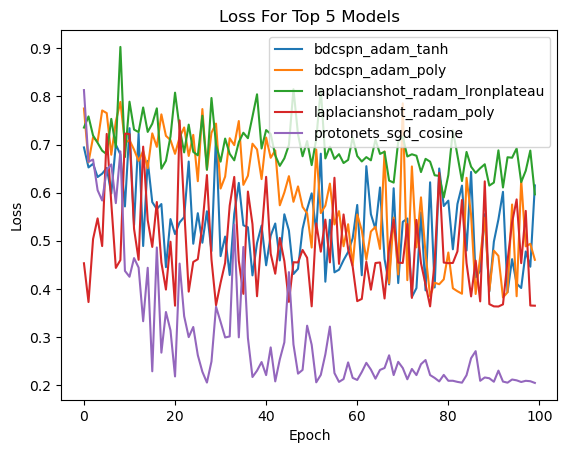

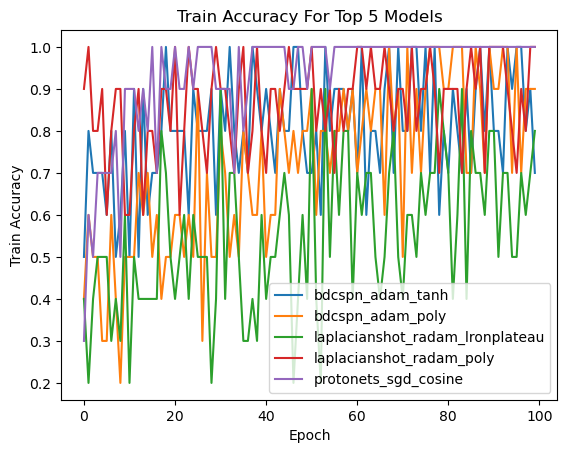

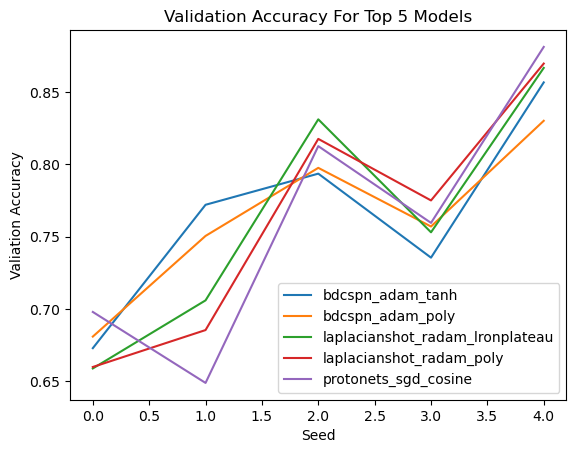

In [81]:
from matplotlib import pyplot as plt
loss_plot = {}
acc_plot = {}
val_acc_plot = {}

for row, data in top5_df.iterrows():
    for key, value in metrics_map.items():
        key = json.loads(key)
        if key['model'] == data['model'] and key['optimizer'] == data['optimizer'] and key['scheduler'] == data['scheduler']:
            l = np.array(value['losses'][0:100])
            loss_plot[f"{key['model']}_{key['optimizer']}_{key['scheduler']}"] = l
            acc_plot[f"{key['model']}_{key['optimizer']}_{key['scheduler']}"] = np.array(value['accuracies'][0:100])
            val_acc_plot[f"{key['model']}_{key['optimizer']}_{key['scheduler']}"] = np.array(value['validation_accuracies'])

print(loss_plot.keys())

for key, value in loss_plot.items():
    plt.plot(value, label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss For Top 5 Models')
plt.legend()
plt.show()

for key, value in acc_plot.items():
    plt.plot(value, label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy For Top 5 Models')

plt.legend()
plt.show()

for key, value in val_acc_plot.items():
    plt.plot(value, label=key)
    plt.xlabel('Seed')
    plt.ylabel('Valiation Accuracy')
    plt.title('Validation Accuracy For Top 5 Models')
plt.legend()
plt.show()


In [8]:
!conda install vit-pytorch -y

Channels:
 - defaults
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/nishant/anaconda3/envs/comp691

  added / updated specs:
    - vit-pytorch


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    einops-0.7.0               |     pyhd8ed1ab_1          39 KB  conda-forge
    vit-pytorch-1.6.7          |     pyhd8ed1ab_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         103 KB

The following NEW packages will be INSTALLED:

  einops             conda-forge/noarch::einops-0.7.0-pyhd8ed1ab_1 
  vit-pytorch        conda-forge/noarch::vit-pytorch-1.6.7-pyhd8ed1ab_0 



einops-0.7.0         | 39 KB     |                                       |   0% 
einops-0.7.0         | 39 KB     | ###############################

Tests with ViT

In [6]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from numpy.random import RandomState
from torch.utils.data import Subset
import numpy as np
import torch


batch_size = 128
n_workers = 1

cifar_data = CIFAR10(root="data", train=True, download=True,  transform= transforms.Compose([
            # transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            # transforms.GaussianBlur(3),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]))

cifar_data_val = CIFAR10(root='.',train=True, transform= transforms.Compose([
            # transforms.RandomResizedCrop(image_size),
            # transforms.RandomHorizontalFlip(),
            
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]), download=True)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
def get_dataloader_transformer(dataset,dataset_val, n_workers, seed, batch_size=128):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 500))
    classes =  prng.permutation(np.arange(0,10))
    indx_train = np.concatenate([np.where(np.array(dataset.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(dataset_val.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])
    train_targets = np.array(dataset.targets)[indx_train]
    val_targets = np.array(dataset.targets)[indx_val]
    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data_val, indx_val)
        
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers,
        pin_memory=True,
    )    
    
    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers,
        pin_memory=True,
    )
    return train_loader, val_loader

In [8]:
def training_epoch_transformer(
    model, data_loader, optimizer, criterion
):
    all_loss = []
    accuracies = []
    model.train()
    
    for batch, (
        images, labels
    ) in enumerate(data_loader):
        optimizer.zero_grad()
        
        classification_scores = model(images.to(device))
        
        
        loss = criterion(classification_scores, labels.to(device))
        loss.backward()
        optimizer.step()
        accuracy = (classification_scores.argmax(dim=1) == labels.to(device)).float().mean()
        accuracies.append(accuracy.item())
        all_loss.append(loss.item())

        # tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss), all_loss, accuracies


def evaluate(
    model, data_loader,
):
    accuracies = []
    model.train()
    
    for batch, (
        images, labels
    ) in enumerate(data_loader):
        model.eval()
        classification_scores = model(images.to(device))
        
        accuracy = (classification_scores.argmax(dim=1) == labels.to(device)).float().mean()
        accuracies.append(accuracy.item())

    return  accuracies

In [9]:
import torch
from vit_pytorch.vit_for_small_dataset import ViT

def get_model(patch_size=16, dim=512, depth=3, heads=16):
    return ViT(
        image_size = 32,
        patch_size = patch_size,
        num_classes = 10,
        dim = dim,
        depth = depth,
        heads = heads,
        mlp_dim = 1024,
        dropout = 0.1,
        emb_dropout = 0.1
    )




In [12]:
from sklearn import metrics
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.loss import LabelSmoothingCrossEntropy
import pickle 
import json
from statistics import mean
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


n_epochs = 150

patch_sizes = [4, 8]
dims = [256, 512, 1024]
depths = [3, 6]
heads = [4, 8]

metrics_map = {}

for patch in patch_sizes:
    for dim in dims:
        for depth in depths:
            for head in heads:
                
                model_info = {'patch': patch, 'dim': dim, 'depth': depth, 'head': head}
                
                model_name = json.dumps(model_info)
                print(model_name)
                v = get_model(patch, dim, depth, head)
                v = v.to(device)


                train_optimizer = Adam(v.parameters(), lr=3e-4)
                criterion = LabelSmoothingCrossEntropy()
                
                train_scheduler = CosineLRScheduler(
                        train_optimizer,  t_initial=5
                    )

                
                
                losses = np.array([])
                train_accuracies = np.array([])
                test_accuracies = np.array([])
                times = np.array([])
                for seed in range(5):
                    train_loader, val_loader = get_dataloader_transformer(cifar_data,cifar_data_val, n_workers, seed)
                    
                    start = torch.cuda.Event(enable_timing=True)
                    start.record()
                    for epoch in range(n_epochs):
                        # print(f"Epoch {epoch}")
                        average_loss, loss, accuracy = training_epoch_transformer(v, train_loader, train_optimizer, criterion)

                        train_scheduler.step(average_loss)
                        if epoch % 10 == 0:
                            print(f"Epoch {epoch} - Loss: {average_loss}, lr: {train_optimizer.param_groups[0]['lr']}")
                        losses = np.append(losses,loss)
                        train_accuracies = np.append(train_accuracies,accuracy)
                    end = torch.cuda.Event(enable_timing=True)
                    end.record()
                    torch.cuda.synchronize()
                    times = np.append(times,(start.elapsed_time(end)/1000))
                    #wait for everything to finish running
                    test_accuracy = evaluate(
                        v, val_loader
                    )
                    print(
                        f"Accuracy: {100* np.array(test_accuracy).mean():.3f}%, time: {start.elapsed_time(end)/1000:.3f}s"
                    )
                    test_accuracies = np.append(test_accuracies,test_accuracy)

                print(
                        f"Accuracy: {100* np.array(test_accuracies).mean():.3f}% \u00B1 {100*np.array(test_accuracies).std():.3f}%, time: {np.array(times).mean():.3f}s \u00B1 {np.array(times).std():.3f}s"
                    )
                metrics_map[model_name] = {'losses': losses, 'train_accuracies': train_accuracies, 'test_accuracies': test_accuracies, 'times': times}
                with open('metrics-vit.pkl', 'wb') as f:
                    pickle.dump(metrics_map, f)



{"patch": 4, "dim": 256, "depth": 3, "head": 4}
Epoch 0 - Loss: 2.1906039714813232, lr: 0.00017897657153135755
Epoch 10 - Loss: 1.0446423292160034, lr: 0.00026883206625515917
Epoch 20 - Loss: 0.9420034289360046, lr: 0.0002744841376517024
Epoch 30 - Loss: 0.739622950553894, lr: 0.0002840921436387696
Epoch 40 - Loss: 0.5858199000358582, lr: 0.00028995290835257746
Epoch 50 - Loss: 0.5380914211273193, lr: 0.0002915083460167981
Epoch 60 - Loss: 0.521094024181366, lr: 0.0002920316199011418
Epoch 70 - Loss: 0.5104044079780579, lr: 0.0002923524115820639
Epoch 80 - Loss: 0.5164762139320374, lr: 0.00029217098572256137
Epoch 90 - Loss: 0.5092889070510864, lr: 0.0002923855175981669
Epoch 100 - Loss: 0.5063638687133789, lr: 0.00029247199514060413
Epoch 110 - Loss: 0.5038757920265198, lr: 0.0002925451753396305
Epoch 120 - Loss: 0.5043011903762817, lr: 0.00029253268805602857
Epoch 130 - Loss: 0.503226637840271, lr: 0.000292564211198453
Epoch 140 - Loss: 0.5026065111160278, lr: 0.0002925823737030347
A

In [18]:
#save metrics to pkl file
import pickle
import pandas as pd

with open('metrics-vit.pkl', 'wb') as f:
    pickle.dump(metrics_map, f)
    
# with open('metrics-vit.pkl', 'rb') as f:
#     metrics_map = pickle.load(f)

metrics_df = pd.DataFrame(columns=['patch','dim', 'depth' ,'head', 'accuracy' ,'time'])
#{"patch": 8, "dim": 1024, "depth": 6, "head": 8}

for key, value in metrics_map.items():
    key = json.loads(key)
    me = {'patch': key['patch'], 'dim': key['dim'], 'depth': key['depth'], 'head': key['head'],
            'accuracy': '%.2f +- %.2f'%(100* np.array(value['test_accuracies']).mean(), 100*np.array(value['test_accuracies']).std()),
            'time': '%.2f +- %.2f'%(value['times'].mean(), value['times'].std()),
            }
    
    metrics_df.loc[len(metrics_df)] = me





metrics_df['acc_mean'] = metrics_df['accuracy'].apply(lambda x: float(x.split(' ')[0]))
metrics_df['time_std'] = metrics_df['time'].apply(lambda x: float(x.split(' ')[2]))
metrics_df['time_mean'] = metrics_df['time'].apply(lambda x: float(x.split(' ')[0]))
metrics_df



metrics_df.sort_values(by='acc_mean', ascending=False, inplace=True)
top5_df = metrics_df.head(5)


top5_df

,patch,dim,depth,head,accuracy,time,acc_mean,time_std,time_mean
4,4,512,3,4,77.03 +- 9.84,10.00 +- 0.07,77.03,0.07,10.00
6,4,512,6,4,76.91 +- 9.39,15.13 +- 0.21,76.91,0.21,15.13
1,4,256,3,8,76.56 +- 10.55,9.13 +- 0.08,76.56,0.08,9.13
7,4,512,6,8,76.52 +- 9.58,19.35 +- 0.15,76.52,0.15,19.35
11,4,1024,6,8,75.82 +- 9.59,30.68 +- 0.09,75.82,0.09,30.68


dict_keys(['PatchSize: 4 Dim:512 Depth:3 Heads:4', 'PatchSize: 4 Dim:512 Depth:6 Heads:4', 'PatchSize: 4 Dim:256 Depth:3 Heads:8', 'PatchSize: 4 Dim:512 Depth:6 Heads:8', 'PatchSize: 4 Dim:1024 Depth:6 Heads:8'])


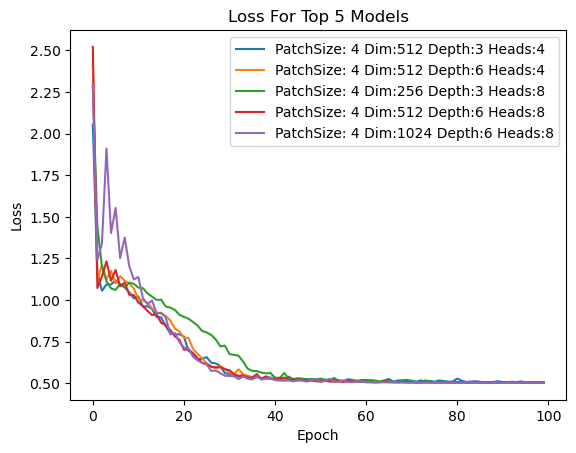

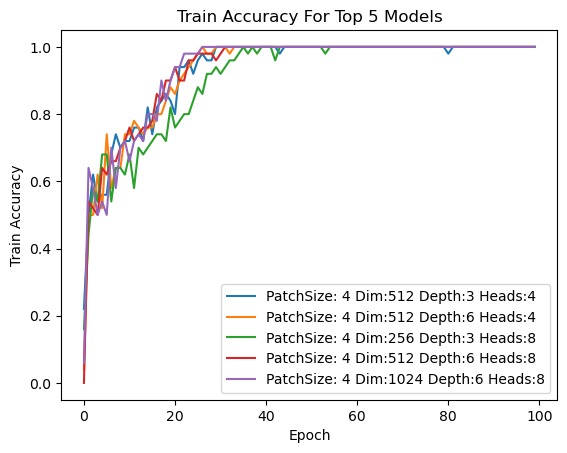

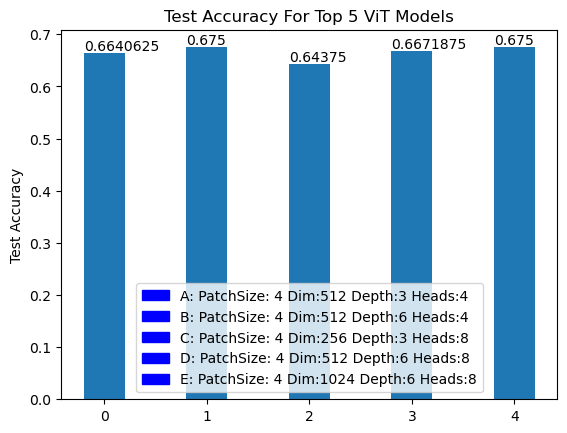

In [51]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

loss_plot = {}
acc_plot = {}
val_acc_plot = {}

for row, data in top5_df.iterrows():
    for key, value in metrics_map.items():
        key = json.loads(key)
        if key['patch'] == data['patch'] and key['dim'] == data['dim'] and key['depth'] == data['depth'] and key['head']==data['head']:
            l = np.array(value['losses'][0:100])
            loss_plot[f"PatchSize: {key['patch']} Dim:{key['dim']} Depth:{key['depth']} Heads:{key['head']}"] = l
            acc_plot[f"PatchSize: {key['patch']} Dim:{key['dim']} Depth:{key['depth']} Heads:{key['head']}"] = np.array(value['train_accuracies'][0:100])
            val_acc_plot[f"PatchSize: {key['patch']} Dim:{key['dim']} Depth:{key['depth']} Heads:{key['head']}"] = np.array(value['test_accuracies'][0:5])

print(loss_plot.keys())

for key, value in loss_plot.items():
    plt.plot(value, label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss For Top 5 Models')
plt.legend()
plt.show()

for key, value in acc_plot.items():
    plt.plot(value, label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy For Top 5 Models')

plt.legend()
plt.show()



keys = [
    'A', 'B', 'C', 'D', 'E'
]

val_accs = [value.mean() for key, value in val_acc_plot.items()]
y_pos = range(len(keys))
bars = plt.bar(y_pos, val_accs, width = 0.4)
plt.ylabel('Test Accuracy')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.title('Test Accuracy For Top 5 ViT Models')

patches = [mpatches.Patch(color='blue') for k in keys]  
labels = ['A: PatchSize: 4 Dim:512 Depth:3 Heads:4', 'B: PatchSize: 4 Dim:512 Depth:6 Heads:4', 'C: PatchSize: 4 Dim:256 Depth:3 Heads:8', 'D: PatchSize: 4 Dim:512 Depth:6 Heads:8', 'E: PatchSize: 4 Dim:1024 Depth:6 Heads:8']
plt.legend(patches, labels)
plt.show()
